In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob
from matplotlib.colors import ListedColormap
from enum import Enum


In [2]:
train = pd.read_csv('../data/preprocessed_train.csv')
test = pd.read_csv('../data/preprocessed_test.csv')

In [3]:
train.head()

,title,author,text,label,removed_punc,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide We Didn’t Even See Comey’s Lett...,"['house', 'dem', 'aide', 'we', 'didn’t', 'even...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...",house aide didn’t even comey’s letter jason ch...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,Ever get the feeling your life circles the rou...,"['ever', 'get', 'the', 'feeling', 'your', 'lif...","['ever', 'feeling', 'your', 'life', 'circles',...","['ever', 'feeling', 'life', 'circles', 'rounda...","['ever', 'feeling', 'life', 'circle', 'roundab...",ever feeling life circle roundabout rather hea...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired October 29 2...,"['why', 'the', 'truth', 'might', 'get', 'you',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...",truth might fired october 2016 tension intelli...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Videos 15 Civilians Killed In Single US Airstr...,"['videos', '15', 'civilians', 'killed', 'in', ...","['videos', 'civilians', 'killed', 'single', 'a...","['videos', 'civilians', 'killed', 'single', 'a...","['video', 'civilian', 'killed', 'single', 'air...",video civilian killed single airstrike identif...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Print \nAn Iranian woman has been sentenced to...,"['print', 'an', 'iranian', 'woman', 'has', 'be...","['print', 'iranian', 'woman', 'been', 'sentenc...","['print', 'iranian', 'woman', 'sentenced', 'ye...","['print', 'iranian', 'woman', 'sentenced', 'ye...",print iranian woman sentenced year prison iran...


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18241 entries, 0 to 18240
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            18241 non-null  object
 1   author           18241 non-null  object
 2   text             18241 non-null  object
 3   label            18241 non-null  int64 
 4   removed_punc     18241 non-null  object
 5   tokens           18241 non-null  object
 6   filtered_tokens  18241 non-null  object
 7   clean_tokens     18241 non-null  object
 8   lemma_words      18241 non-null  object
 9   clean_text       18167 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.4+ MB


In [5]:
test.head()

,title,author,text
0,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
2,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
3,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
4,Pelosi Calls for FBI Investigation to Find Out...,Pam Key,"Sunday on NBC’s “Meet the Press,” House Minori..."


# EDA

In [7]:
colors = ["#D8E8E8", "#A8D0DA", "#406D96", "#2F3A56", "#E2474B"]
sns.set_palette(sns.color_palette(colors))

## Pie Chart

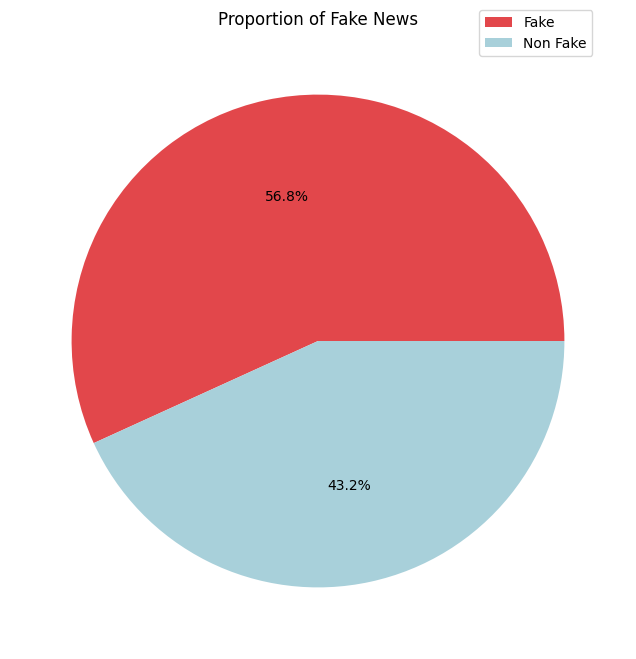

In [8]:
type_counts = train['label'].value_counts()
labels = ['Fake', 'Non Fake']

total_count = sum(type_counts)
percentages = type_counts / total_count * 100

plt.figure(figsize=(8, 8))
plt.pie(percentages, autopct='%1.1f%%', colors=[colors[4], colors[1]])
plt.legend(labels, loc="center left", bbox_to_anchor=(0.75, 1))
plt.title('Proportion of Fake News')
plt.show()

## Title word cloud

In [9]:
fake_news_df = train[train['label'] == True].copy()
non_fake_news_df = train[train['label'] == False].copy()

In [10]:
wordcloud_fake = WordCloud(width=800, height=400, random_state=123, background_color='white').generate(fake_news_df['clean_text'].to_string())

In [11]:
wordcloud_non_fake = WordCloud(width=800, height=400, random_state=123, background_color='white').generate(non_fake_news_df['clean_text'].to_string())

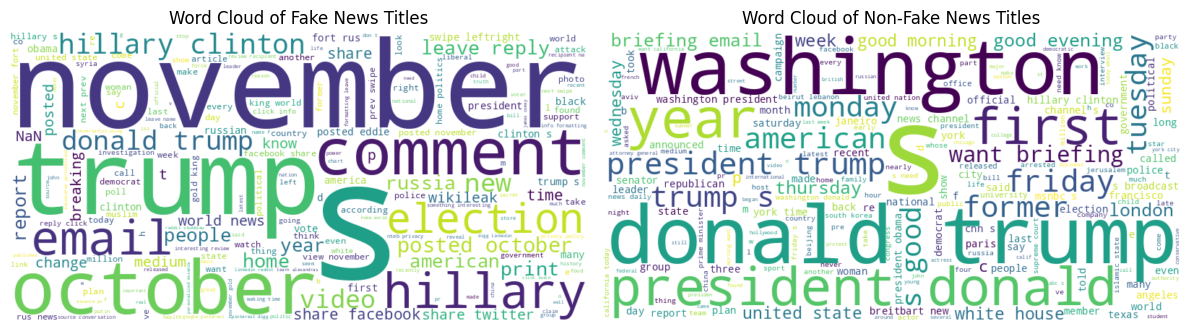

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('Word Cloud of Fake News Titles')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_fake, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('Word Cloud of Non-Fake News Titles')

plt.tight_layout()
plt.show()

## Sentiment Analysis

### Sentiment Scatter

In [13]:
fake_news_df['title_sentiment'] = fake_news_df['title'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
fake_news_df['content_sentiment'] = fake_news_df['clean_text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

non_fake_news_df['title_sentiment'] = non_fake_news_df['title'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
non_fake_news_df['content_sentiment'] = non_fake_news_df['clean_text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

In [14]:
# Calculate correlation between title and content sentiment for both DataFrames
fake_correlation = fake_news_df[['content_sentiment', 'title_sentiment']].corr().iloc[0, 1]
non_fake_correlation = non_fake_news_df[['content_sentiment', 'title_sentiment']].corr().iloc[0, 1]

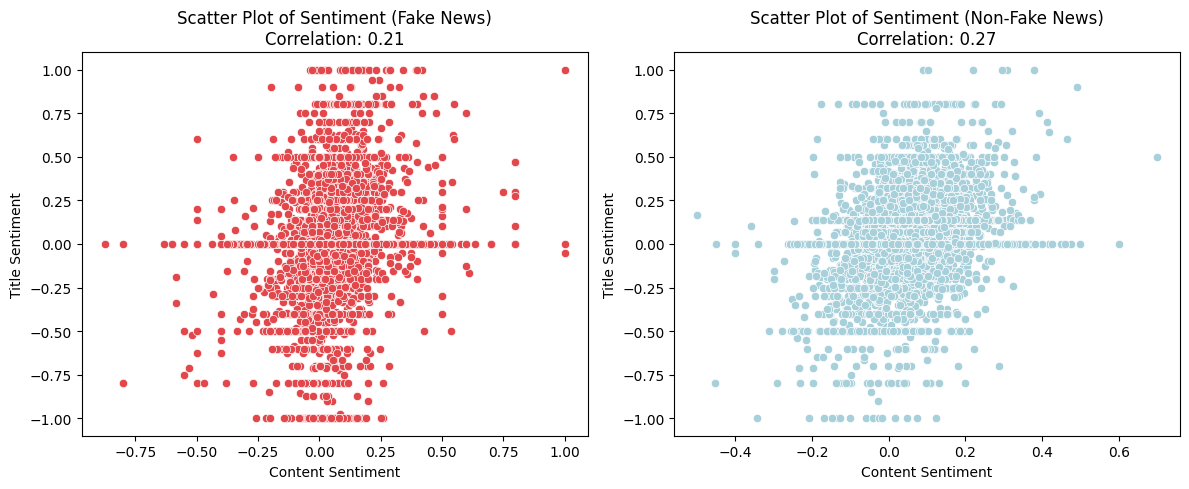

In [15]:
# Create scatter plots for "fake" and "non-fake" news with correlation in title
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='content_sentiment', y='title_sentiment', data=fake_news_df, color=colors[4])
plt.xlabel('Content Sentiment')
plt.ylabel('Title Sentiment')
plt.title(f'Scatter Plot of Sentiment (Fake News)\nCorrelation: {fake_correlation:.2f}')

plt.subplot(1, 2, 2)
sns.scatterplot(x='content_sentiment', y='title_sentiment', data=non_fake_news_df, color=colors[1])
plt.xlabel('Content Sentiment')
plt.ylabel('Title Sentiment')
plt.title(f'Scatter Plot of Sentiment (Non-Fake News)\nCorrelation: {non_fake_correlation:.2f}')

plt.tight_layout()
plt.show()

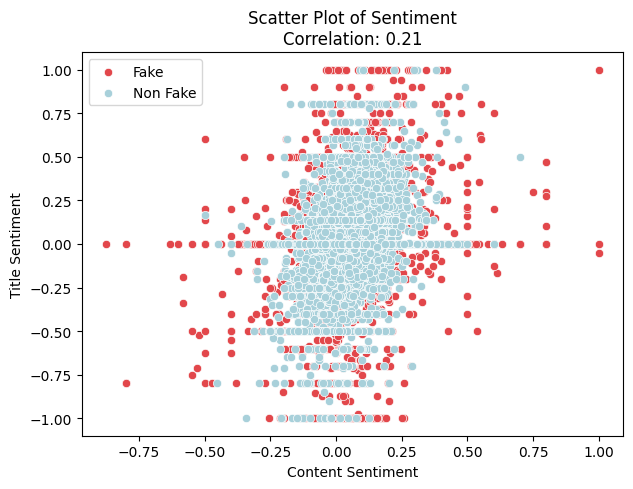

In [16]:
# Create scatter plots for "fake" and "non-fake" news with correlation in title
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='content_sentiment', y='title_sentiment', data=fake_news_df, alpha=1, color=colors[4], label="Fake")
sns.scatterplot(x='content_sentiment', y='title_sentiment', data=non_fake_news_df, alpha=1, color=colors[1], label="Non Fake")
plt.xlabel('Content Sentiment')
plt.ylabel('Title Sentiment')
plt.title(f'Scatter Plot of Sentiment\nCorrelation: {fake_correlation:.2f}')
plt.legend()


plt.tight_layout()
plt.show()

### Sentiment heatmap

In [17]:
class Polarity(Enum):
    NEGATIVE = 0
    NEUTRAL = 1
    POSITIVE = 2

def discretize_sentiment(polarity):
    if polarity < -1/5: return Polarity.NEGATIVE.name
    elif -1/5 <= polarity <= 1/5: return Polarity.NEUTRAL.name
    return Polarity.POSITIVE.name

fake_news_df['title_sentiment_category'] = fake_news_df['title_sentiment'].apply(discretize_sentiment)
fake_news_df['content_sentiment_category'] = fake_news_df['content_sentiment'].apply(discretize_sentiment)

non_fake_news_df['title_sentiment_category'] = non_fake_news_df['title_sentiment'].apply(discretize_sentiment)
non_fake_news_df['content_sentiment_category'] = non_fake_news_df['content_sentiment'].apply(discretize_sentiment)

In [18]:
polarities = [polarity.name for polarity in Polarity]
polarities

['NEGATIVE', 'NEUTRAL', 'POSITIVE']

In [19]:
# Create pivot tables for the heatmaps and fill missing values


pivot_fake = fake_news_df.pivot_table(index='title_sentiment_category', columns='content_sentiment_category', aggfunc='size', fill_value=0)
pivot_fake = pivot_fake.reindex(columns=polarities, index=polarities, fill_value=0)

pivot_non_fake = non_fake_news_df.pivot_table(index='title_sentiment_category', columns='content_sentiment_category', aggfunc='size', fill_value=0)
pivot_non_fake = pivot_non_fake.reindex(columns=polarities, index=polarities, fill_value=0)

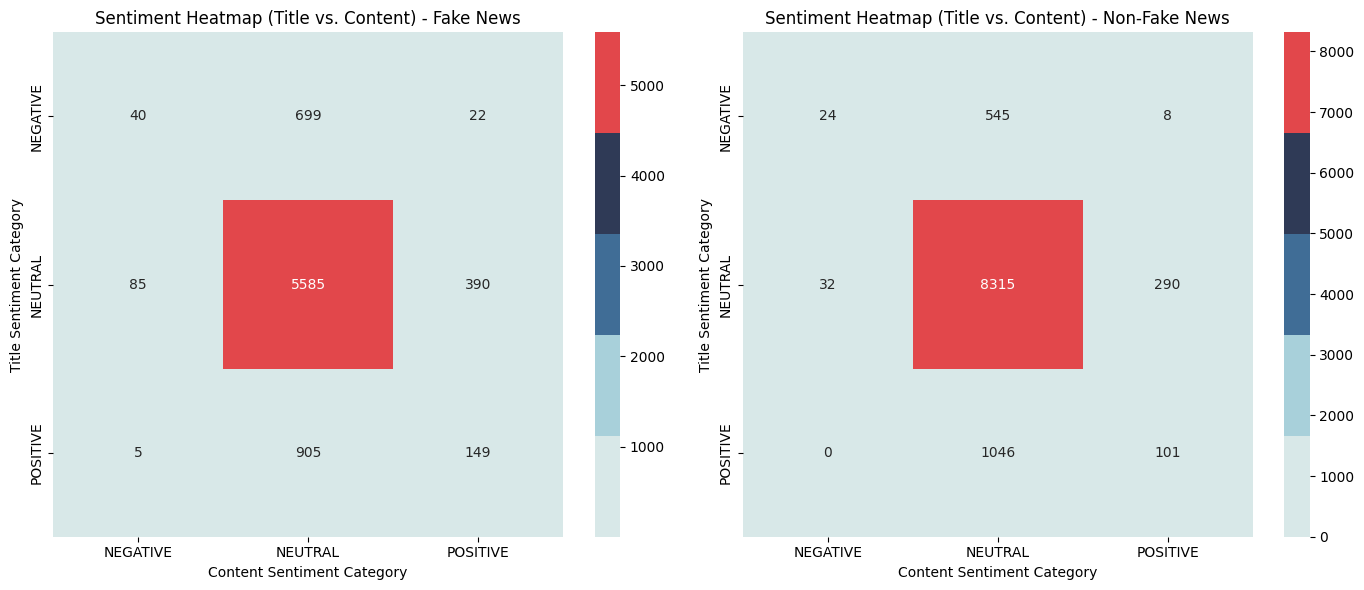

In [20]:
# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the heatmap for "fake" news
sns.heatmap(pivot_fake, annot=True, fmt='d', cmap=ListedColormap(colors), cbar=True, ax=axes[0])
axes[0].set_xlabel('Content Sentiment Category')
axes[0].set_ylabel('Title Sentiment Category')
axes[0].set_title('Sentiment Heatmap (Title vs. Content) - Fake News')

# Plot the heatmap for "non-fake" news
sns.heatmap(pivot_non_fake, annot=True, fmt='d', cmap=ListedColormap(colors), cbar=True, ax=axes[1])
axes[1].set_xlabel('Content Sentiment Category')
axes[1].set_ylabel('Title Sentiment Category')
axes[1].set_title('Sentiment Heatmap (Title vs. Content) - Non-Fake News')

plt.tight_layout()
plt.show()

In [21]:
sentiment_analysis = train.copy()
sentiment_analysis['title_sentiment'] = sentiment_analysis['title'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
sentiment_analysis['content_sentiment'] = sentiment_analysis['text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
sentiment_analysis['title_sentiment_category'] = sentiment_analysis['title_sentiment'].apply(discretize_sentiment)
sentiment_analysis['content_sentiment_category'] = sentiment_analysis['content_sentiment'].apply(discretize_sentiment)

In [22]:
sentiment_analysis['label'].value_counts()

label
0    10361
1     7880
Name: count, dtype: int64

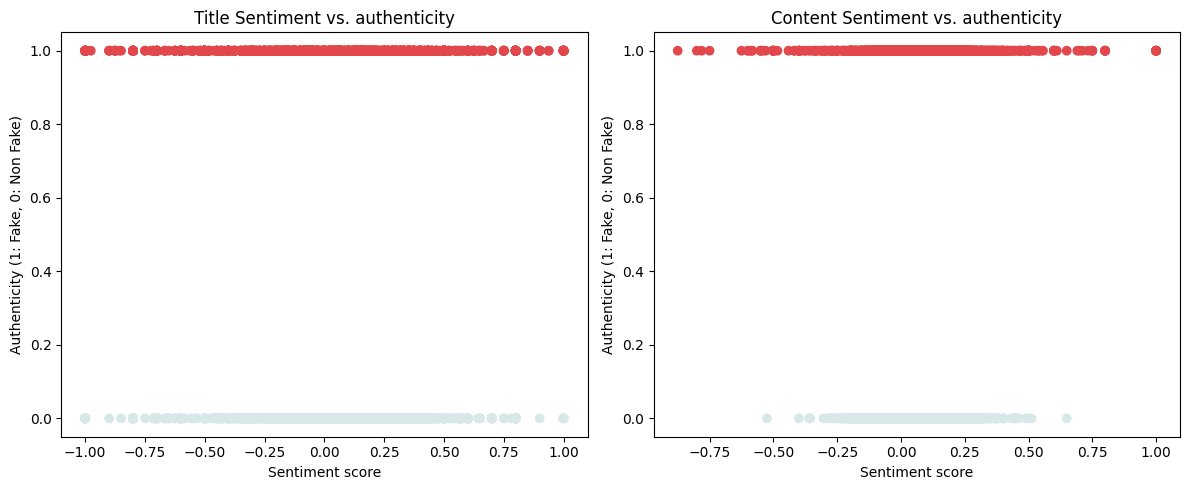

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(sentiment_analysis['title_sentiment'], sentiment_analysis['label'], c=sentiment_analysis['label'], cmap=ListedColormap(colors))
plt.xlabel('Sentiment score')
plt.ylabel('Authenticity (1: Fake, 0: Non Fake)')
plt.title('Title Sentiment vs. authenticity')

plt.subplot(1, 2, 2)
plt.scatter(sentiment_analysis['content_sentiment'], sentiment_analysis['label'], c=sentiment_analysis['label'], cmap=ListedColormap(colors))
plt.xlabel('Sentiment score')
plt.ylabel('Authenticity (1: Fake, 0: Non Fake)')
plt.title('Content Sentiment vs. authenticity')

plt.tight_layout()
plt.show()

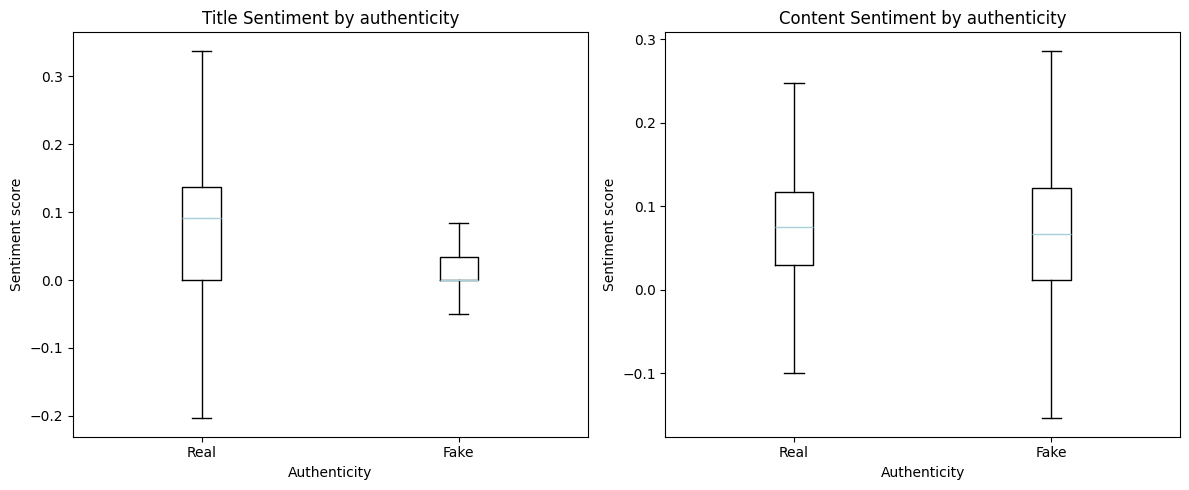

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
real_sentiment_scores = [score for score, label in zip(sentiment_analysis['title_sentiment'], sentiment_analysis['label']) if not label]
fake_sentiment_scores = [score for score, label in zip(sentiment_analysis['title_sentiment'], sentiment_analysis['label']) if label]
plt.boxplot([real_sentiment_scores, fake_sentiment_scores], labels=['Real', 'Fake'], showfliers=False, flierprops = dict(markersize = 0.2))
plt.xlabel('Authenticity')
plt.ylabel('Sentiment score')
plt.title('Title Sentiment by authenticity')

plt.subplot(1, 2, 2)
real_sentiment_scores = [score for score, label in zip(sentiment_analysis['content_sentiment'], sentiment_analysis['label']) if not label]
fake_sentiment_scores = [score for score, label in zip(sentiment_analysis['content_sentiment'], sentiment_analysis['label']) if label]
plt.boxplot([real_sentiment_scores, fake_sentiment_scores], labels=['Real', 'Fake'], showfliers=False, flierprops = dict(markersize = 0.2))
plt.xlabel('Authenticity')
plt.ylabel('Sentiment score')
plt.title('Content Sentiment by authenticity')

plt.tight_layout()
plt.show()

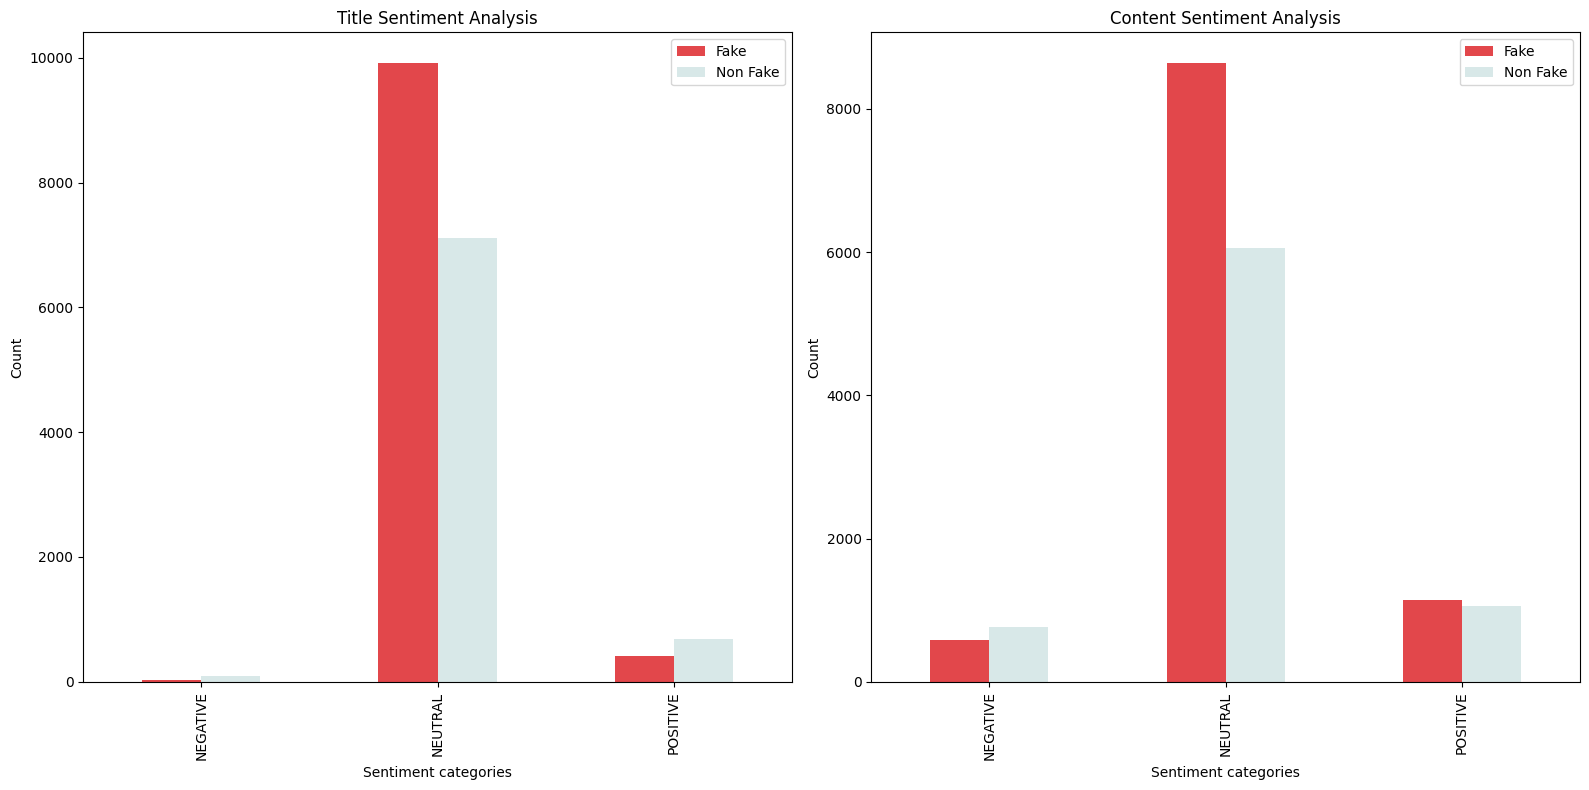

In [25]:
pivot_table_title = pd.pivot_table(sentiment_analysis, values='title_sentiment_category', index=['content_sentiment_category'], columns=['label'], aggfunc=len)
pivot_table_content = pd.pivot_table(sentiment_analysis, values='content_sentiment_category', index=['title_sentiment_category'], columns=['label'], aggfunc=len)

# Configurar el tamaño y diseño de los subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Primer subplot para el análisis de títulos
pivot_table_title.plot(kind='bar', stacked=False, colormap=ListedColormap(colors[::-1]), ax=axes[0])

# Configurar el título y las etiquetas del primer subplot
axes[0].set_title('Title Sentiment Analysis')
axes[0].set_xlabel('Sentiment categories')
axes[0].set_ylabel('Count')
axes[0].legend(labels)

# Segundo subplot para el análisis de contenido
pivot_table_content.plot(kind='bar', stacked=False, colormap=ListedColormap(colors[::-1]), ax=axes[1])

# Configurar el título y las etiquetas del segundo subplot
axes[1].set_title('Content Sentiment Analysis')
axes[1].set_xlabel('Sentiment categories')
axes[1].set_ylabel('Count')
axes[1].legend(labels)

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()

# Mostrar los subplots
plt.show()